# Hamiltonian Monte Carlo

We have seen that the guess and check strategy of the MCMC methods perform miserably in High-Dimensions as there are exponentially many directions to choose from and only limited number of directions which are along the Typical Set.

This motivates us to make algorithms that use the geometry of the Typical Set to take the next step rather than guessing our jumps. Specifically, we need transitions that can follow those contours of high probability mass, coherently gliding through the typical set.

Hamiltonian Monte Carlo Methods are one such methods that work with the geometery and find transitions which move along the Typical Set.

Let us Clear one misconception first: People often claim that HMC is better as it leverages gradients, but this is not true. While yes, gradients give us much more information than just the pdf values, but the real reason is HMC uses these gradients to glide and move along the typical set and choose high probability steps, helping us trace the narrow high probability density shell


## Using Vector Fields

One way of using geometry to guide our transitions will be to use vector fields which are aligned with the typical set. In other words, instead of fumbling around parameter space with random, uninformed jumps, we can follow the direction assigned to each at point for a small distance. By construction this will move us to a new point in the typical set, where we will find a new direction to follow.

So, the vector field that we want to achieve looks somewhat like this ([Credits](https://arxiv.org/abs/1701.02434)): 

```{figure} ../images/Simulation/Target_dist.png
---
height: 300px
width: 300px
name: Target_dist
---
Required Vector Field
```

To get this, sort of configuration, we will need to use the gradients, but we soon run into problems. The gradient vector field based on the Target pdf does not follow the Typical set (which we want), rather it follows straight into the mode of the distribution (which it should).

```{figure} ../images/Simulation/Grad_dist.png
---
height: 300px
width: 300px
name: Grad_dist
---
Gradient Vector Field
```

In order to generate motion through the typical set we need to introduce additional structure that carefully twists the gradient into alignment with the typical set. The additional structure that we include are momentum parameters in addition to the original parameters.

In an analogy to classical mechanics (complete explaination requires differential geometry), we assume the parameters to be space parameters and add same number of momentum parameters. Assume a satellite in the gradient field. If left as it is, the craft will fall directly into the mode, but if we give it the correct momentum, then the trajectory will make it move in a stable orbit around the planet.

Similarly, if we add the momentum parameters in the correct amount, the resulting trajectory of the sample will move along the Typical Set instead of falling into the mode.

## Phase Space and Hamiltons Equations

Conservative dynamics in physical systems requires that volumes are exactly preserved. As the system evolves, any compression or expansion in position space must be compensated with a respective expansion or compression in momentum space to ensure that the volume of any neighborhood in position-momentum phase space is unchanged. 

We introduce new momentum parameters $p_n$ to complement each dimension of the position space. Ie we lift the $D$ dimensional parameter space to the higher $2D$ dimensional phase space.

$$
q_n \to (q_n , p_n)
$$

Consecuently, we also lift the target distribution onto a joint probability distribution on phase space called the canonical distribution.

$$
\pi (q, p) = T(p|q) \pi(q) 
$$

Ie, we had the position vector $q$, we lift it to another dimension $(q,p)$, after picking up a momentum vector $p$ based on the trasition pdf $T(p|q)$. Also Note:, We have made a probability distribution on phase space that marginalizes to the target distribution, and we ensured that the typical set on phase space projects to the typical set of the target distribution.

```{figure} ../images/Simulation/travelling.png
---
height: 250px
width: 250px
name: Travelling
---
Travelling over the phase space
```

We can further exted the physics analogy to solve for the trajectory. We will first define the Hamiltonian over the phase space (position + momentum) by the negative log of the joint pdf:

$$
H(q,p) = - log(\pi (q,p))
$$

this decomposes into the Kinetic and the Potential Energies:

\begin{align}
H(q,p) &= -log T(p|q) - log \pi(q) \\
& = + K(p,q) + V(q)
\end{align}

The Kinetic energy depends on the positon and momentum, while the potential energy depends only on the position. We can then solve the Hamilton's differential equations to get the trajectory. 

\begin{align}
& \frac{dq}{dt} &= + \frac{\partial H}{\partial p} &= \frac{\partial K}{\partial p} \\
& \frac{dp}{dt} &= - \frac{\partial H}{\partial q} &= - \frac{\partial K}{\partial q} - \frac{\partial V}{\partial q}
\end{align}

By channeling the gradient through the momentum instead of the target parameters directly, Hamilton’s equations twist differential information to align with the typical set of canonical distribution. 

Following the Hamiltonian vector field for some time, $t$ , generates trajectories, $\phi_t(q, p)$, that rapidly move through phase space while being constrained to the typical set. Projecting these trajectories back down onto the target parameter space finally yields the efficient exploration of the target typical set for which we are searching.

Now, two important questions remain to implement the HMC:

1. How to choose the K: There are a lot of useful rule of thumbs to choose K, but most simple one will work fairly well. In our example, we will use a Multivariate Normal distribution to select the momentum.

2. How to solve the Hamiltons Equation: This is usually done by a method called Symplectic Integrators, a technique which keeps the H fixed. We will use a simplified version of it called the leap-frog integrator.




## Simplified Example

In a simplified example, we will take a spherically symmetric probability distribution to simulate:

$$
U(\theta) = -log (\pi(\theta)) = 20 (|\theta|_2 - 10)^2
$$

with the momentum transition probability being a normal function:

$$
K(r) = \sum_{i = 1}^{d} \frac{1}{2} r_i^2 \; \; with  \; \; r_i \sim \mathcal{N}(0,1)
$$

For this $H(\theta, r)$, we have the Hamiltons equation as:

\begin{align}
& \frac{d \theta_i}{dt} = r_i \\
& \frac{d r_i}{dt}  = \frac{\partial log(\pi(\theta))}{\partial \theta_i} 

\end{align}

For simulating the trajectory, we will use the leapfrog integrator, which works like

\begin{align}
& r(t + \epsilon/2) & = & \; \;  r(t) - (\epsilon /2) \nabla_{\theta} U (\theta(t)) \\
& \theta(t + \epsilon) & = & \; \; \theta(t) + \epsilon r(t + \epsilon/2) \\
& r(t + \epsilon) & = & \; \; r(t+ \epsilon/2) - (\epsilon /2) \nabla_{\theta} U (\theta(t + \epsilon/2)) \\
\end{align}

We will have to choose a suitable $L$ (leapfrog steps), so that the path is neither too long or too short.

We will also select the points based on the Hamiltonian of the new state wrt to the original state. In perfect HMC, this will not be needed as the Hamiltonian is conserved, but in our case, there is error due to the numerical integration, thus we also do the check step of ordinary MCMC.

$$
log (Uniform (0,1)) < H(\theta, r) - H(\theta^{\prime}, r^{\prime})
$$

**Parameters to be tune**

1. $\epsilon$: The value of epsilon effects only the acceptance rate (as it give rise to errors in H). So large $\epsilon$'s cause a larger error in H (hense low acceptance), while a small $\epsilon$ will increase integration time.

2. $L$: Tuning L is more difficult. HMC leapfrog trajectories can resemble the flight path of a boomerang that starts moving away but at some point will turn back to the starting point. At $L = 1$ HMC reduces to random walk MCMC, so larger L are needed to benefit from the more complicated algorithm. At the same time, too large L can at worst lead to very inefficient sampling when the trajectories will return back to their starting point.

This problem is usually mitigated by NUTS sampling, but here will will use a moderately small $\epsilon = 0.2$, and $L = 50$



In [29]:
from jax import random
import jax.numpy as jnp
theta = jnp.array([1.0, 2.0])
random.normal(random.PRNGKey(5), theta.shape)

Array([-1.6729976,  1.3104093], dtype=float32)

Acceptance Rate:  0.91


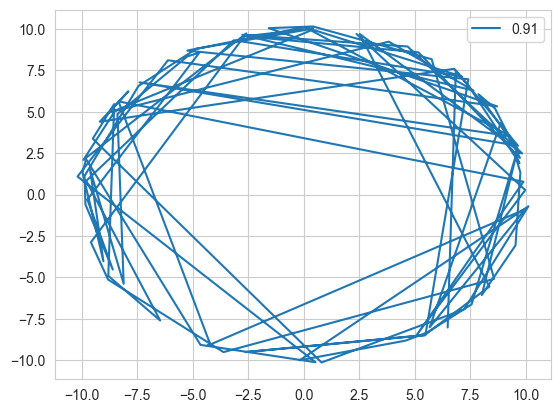

In [73]:
# Coding up the HMC algorithm
import jax.numpy as jnp
from jax import random, grad
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

def HMC(theta0, n, target_f, e, L):
    samples = jnp.zeros((n, len(theta0)))
    theta = jnp.copy(theta0)
    grad_f = grad(target_f)
    gradient = grad_f(theta); logp = target_f(theta)
    accepts = 0
    # For the N samples
    for i in range(n):
        p = random.normal(random.PRNGKey(2*i+1), theta.shape) # Sample a random momentum
        H_current = p.T @ p / 2 - logp                    # Evaluating the Hamiltonian = KE + PE

        pnew = jnp.copy(p); thetanew = jnp.copy(theta); gradientnew = jnp.copy(gradient)
        # L leapfrog steps
        for l in range(L):
            pnew = pnew + e * gradientnew / 2  #### + or -
            thetanew = thetanew + e * pnew
            gradientnew = grad_f(thetanew)
            pnew = pnew + e * gradientnew / 2
        
        logpnew = target_f(thetanew)
        H_new = pnew.T @ pnew / 2 - logpnew

        # Acceptance probability
        if jnp.log(random.uniform(random.PRNGKey(i**2+i))) < H_current - H_new:
            theta = thetanew
            gradient = gradientnew
            logp = logpnew
            accepts += 1
        samples = samples.at[i, :].set(theta)
    return samples, accepts/n

# Spherical Traget Function
def target_f(theta):
    return -20*(jnp.sqrt(jnp.sum(theta**2))-10)**2

samples, accept_rate = HMC(jnp.array([3.0, 0.0]), n = 200, target_f = target_f, e = 0.2, L = 50)

print("Acceptance Rate: ", accept_rate)
# print(samples)

samples = samples[samples.shape[0]//2:]
plt.plot(samples[:,0], samples[:,1], label = accept_rate)
plt.legend()
plt.show()

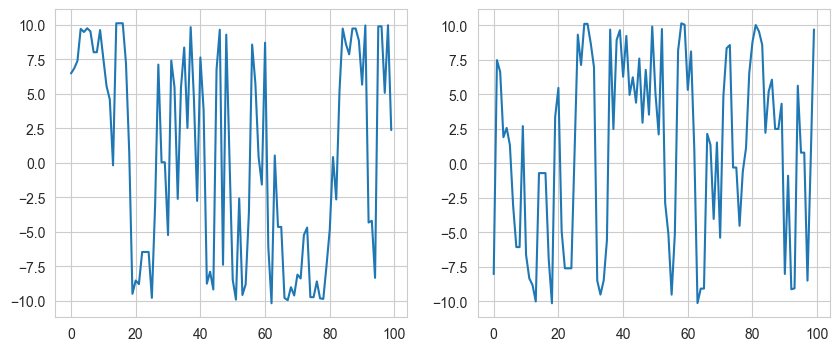

In [72]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(samples[:,0])
ax[1].plot(samples[:,1])

This code shows how well Hamiltonian Monte Carlo works as it moves along the Typical set. On comparison, the simple MCMC does not perform equally well. 

One thing to note is that for each step, we are doing 50 calculations (L =50) instead of 1 (for MCMC), but we will get the full benefits in Higher Dimensions.

**Results**

Times taken by my PC for all dimensions were from 40-50 secounds (High but scales well).

The acceptance rates for all the dimensions were well after tuning the hyperparameters. While dimensions 2 and 3 worked well with $\epsilon = 0.2, L = 50$, dimension 4 gave a very low acceptance as due to high $\epsilon$, there was a significant error in trajectory integration leading to points going outside the Typical Set. On reducing $\epsilon$ to 0.1, the accuracy rose up again.

In [77]:
def target_f3(theta):
    return -30*(jnp.sqrt(jnp.sum(theta**2))-13)**2

samples, accept_rate = HMC(jnp.array([3.0, 0.0, 1.0]), n = 200, target_f = target_f3, e = 0.2, L = 50)
print("Acceptance rate in Dimension 3: ", accept_rate)

Acceptance rate in Dimension 3:  0.84


In [90]:
def target_f4(theta):
    return -50*(jnp.sqrt(jnp.sum(theta**2))-40)**2

samples, accept_rate = HMC(jnp.array([3.0, 0.0, 1.0, 2.0]), n = 200, target_f = target_f4, e = 0.2, L = 50)
print("Acceptance rate in Dimension 4 for e = 0.2, L = 50 is = ", accept_rate)

Acceptance rate in Dimension 4 for e = 0.2, L = 50 is =  0.06


In [94]:
samples4, accept_rate4 = HMC(jnp.array([3.0, 0.0, 1.0, 2.0]), n = 200, target_f = target_f4, e = 0.1, L = 50)
print("Acceptance rate in Dimension 4 for e = 0.1, L = 50 is = ", accept_rate)

Acceptance rate in Dimension 4 for e = 0.1, L = 50 is =  0.935


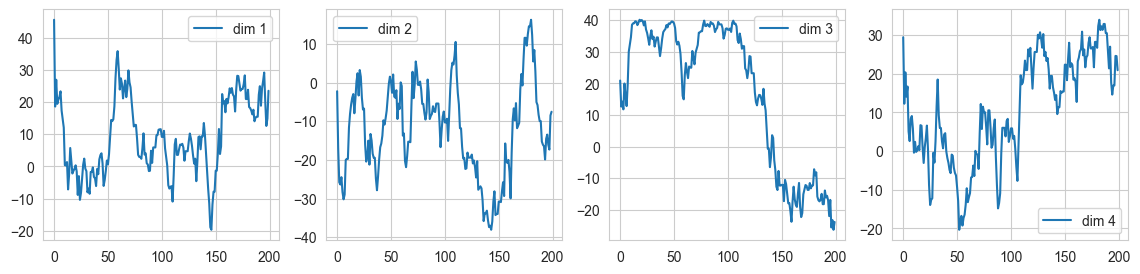

In [97]:
fig, ax = plt.subplots(1, 4, figsize=(14, 3))
ax[0].plot(samples4[:,0], label = "dim 1"); ax[0].legend()
ax[1].plot(samples4[:,1], label = "dim 2"); ax[1].legend()
ax[2].plot(samples4[:,2], label = "dim 3"); ax[2].legend()
ax[3].plot(samples4[:,3], label = "dim 4"); ax[3].legend()
plt.show()

In [102]:
def target_f5(theta):
    return -20*(jnp.sqrt(jnp.sum(theta**2))-10)**2

samples5, accept_rate5 = HMC(jnp.array([3.0, 0.0, 1.0, 2.0, 3.0]), n = 200, target_f = target_f5, e = 0.1, L = 50)
print("Acceptance rate in Dimension 5: ", accept_rate)

Acceptance rate in Dimension 5:  0.935


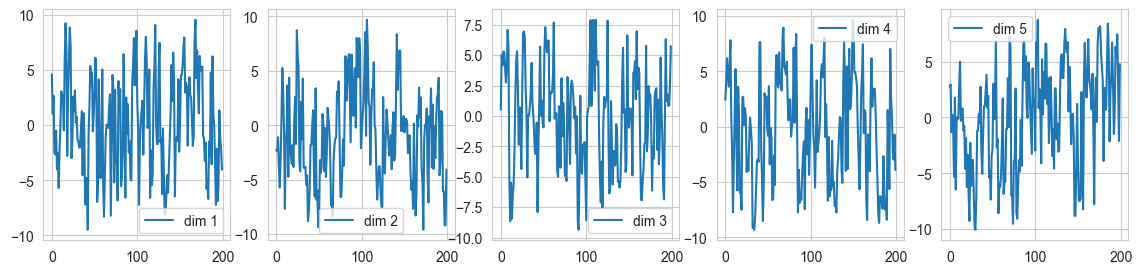

In [103]:
fig, ax = plt.subplots(1, 5, figsize=(14, 3))
for i in range(5):
    ax[i].plot(samples5[:,i], label = "dim {}".format(i+1)); ax[i].legend()

plt.show()

In [105]:
def target_f7(theta):
    return -70*(jnp.sqrt(jnp.sum(theta**2))-40)**2

samples, accept_rate = HMC(jnp.ones(7), n = 200, target_f = target_f7, e = 0.1, L = 50)
print("Acceptance rate in Dimension 7: ", accept_rate)

Acceptance rate in Dimension 7:  0.94


## Issues with HMC

HMC has been made with High Dimensional spaces in mind, but in the case of multimodal distributions, HMC has the same problems as simple MCMC. This issue is mitigated by using tempering chains.

Another important issue is the fact that the trajectories often boomerang to the starting point. This issue is mitigated by using the NUTS sampling.